In [1]:
import numpy as np
from typing import Union, Iterable, Sized, Tuple
import torch
import torch.nn.functional as F
from torch.distributions.uniform import Uniform
import matplotlib.pyplot as plt
import math
import os
import random
import logging
from torch.utils.data import TensorDataset, DataLoader
from absl import app, flags
from tqdm import tqdm

import sys
sys.path.append(r'C:\Users\yuval\dev\MSC\multi-classification-NAM')

from model import ExULayer, ReLULayer, MonotonicLayer, NeuralAdditiveModel, HierarchNeuralAdditiveModel

In [2]:
#!pip install wandb --upgrade

In [3]:
# import wandb
# wandb.login()

# run = wandb.init(
#     project="nam-original",
#     notes="My first experiment",
#     tags=["baseline"],
# )

In [4]:
# Ensure deterministic behavior
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Dataset

In [5]:
def get_synthetic_data_mono(num_exp=10, in_features=10):
    # Simulate independent variables, x0,...,x4 from a Uniform distribution on [−1, 1]
    X_uniform = Uniform(-1, 1).sample((num_exp, in_features-5))
    
    # Simulate features x5 and x6 from a Normal distribution with mean=0 and std=1
    X_normal = torch.normal(0, 1, (num_exp, 5))
    
    # Combine the uniform and normal features
    X = torch.cat([X_uniform, X_normal], dim=1)
    print(X.shape)
    
    # Creating y_1 with monotonic relationship
    y_1 = 2 * X[:, 0] + 0.5*(3*(X[:, 1]**2)-1) + 0.5*(X[:, 2]**3)
    y_1 = y_1.reshape(-1, 1)
    
    # Creating y_2 with monotonic relationship
    y_2 = torch.abs(X[:, 3]) + 0.5 * torch.log(1 + torch.abs(X[:, 4]))
    y_2 = y_2.reshape(-1, 1)
    
    # Creating y_3 with a non-monotonic relationship for contrast
    y_3 = -(3/4) * torch.exp(-4 * X[:, 5].abs()) + torch.cos(5 * X[:, 6])
    y_3 = y_3.reshape(-1, 1)
    
    # Creating y_4 with monotonic relationship
    y_4 = torch.exp(0.5 * X[:, 7]) + 0.5 * (X[:, 8]**2)
    y_4 = y_4.reshape(-1, 1)
    
    # Stack all y_i to form the final target matrix
    y = torch.cat([y_1, y_2, y_3, y_4], dim=1)
    print(y.shape)
    
    return X, y

In [6]:
def get_synthetic_data_phase1(num_exp=10, in_features=10):
    # Simulate independent variables, x0,...,x4 from a Uniform distribution on [−1, 1]
    X_uniform = Uniform(-1, 1).sample((num_exp, in_features-5))
    
    # Simulate features x5 and x6 from a Normal distribution with mean=0 and std=1
    X_normal = torch.normal(0, 1, (num_exp, 5))
    
    # Combine the uniform and normal features
    X = torch.cat([X_uniform, X_normal], dim=1)
    print(X.shape)
    
    # creating y_1
    y_1 = X[:, 0] + 0.5*(3*(X[:, 1]**2)-1) + 0.5*(X[:, 2]**3)
    y_1 = y_1.reshape(-1, 1)
    #print(y_1.shape)
    
    # creating y_2
    y_2 = (1/3) * torch.log(100 * X[:, 5].abs()) + torch.sin(5 * X[:, 6])
    y_2 = y_2.reshape(-1, 1)
    #print(y_2.shape)
    
    # creating y_3
    y_3 = -(3/4) * torch.exp(-4 * X[:, 7].abs()) + torch.cos(5 * X[:, 8])
    y_3 = y_3.reshape(-1, 1)
    
    # creating y_4
    y_4 = torch.sin(5 * X[:, 5]) + 0.5*(3*(X[:, 2]**2)-1)  
    y_4 = y_4.reshape(-1, 1)
    
    # Stack all y_i to form the final target matrix
    y = torch.cat([y_1, y_2, y_3, y_4], dim=1)
    print(y.shape)
    
    return X, y


def get_synthetic_data_phase2(X_input):
    
    # creating y_1
    y_1 = 4*X_input[:, 0] + 0.5*X_input[:, 1]
    y_1 = y_1.reshape(-1, 1)
    #print(y_1.shape)
    
    # creating y_2
    y_2 = (1/3) * X_input[:, 2] + 5 * X_input[:, 3]
    y_2 = y_2.reshape(-1, 1)
    #print(y_2.shape)
    
    # Stack all y_i to form the final target matrix
    y = torch.cat([y_1, y_2], dim=1)
    print(y.shape)
    
    return y


def make_loader(X, y, batch_size):
    dataset = TensorDataset(torch.tensor(X), torch.tensor(y))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

In [7]:
X, y_phase1 = get_synthetic_data_phase1(num_exp=1, in_features=10)
y_phase2 = get_synthetic_data_phase2(y_phase1)

torch.Size([1, 10])
torch.Size([1, 4])
torch.Size([1, 2])


# MODEL

# Loss

In [8]:
# Loss function for regression
def feature_loss(fnn_out, lambda_=0.):
    return lambda_ * (fnn_out ** 2).sum() / fnn_out.shape[1]

def penalized_mse(logits, truth, fnn_out, feature_penalty=0.0):
    feat_loss = feature_loss(fnn_out, feature_penalty)
    mse_loss = F.mse_loss(logits.view(-1), truth.view(-1))
    loss = mse_loss+feat_loss
    return loss

def l1_penalty(params, l1_lambda):
    l1_norm =  torch.stack([torch.linalg.norm(p, 1) for p in params], dim=0).sum()
    return l1_lambda*l1_norm

def l2_penalty(params, l1_lambda):
    l2_norm =  torch.stack([torch.linalg.norm(p, 2) for p in params], dim=0).sum()
    return l1_lambda*l2_norm

# Model training

In [9]:
def train(model, loader, criterion, optimizer, config):
    
    # Run training and track with wandb
#    total_batches = len(loader) * config['epochs']
#    batch_ct = 0
    loss_history = []

    for epoch in tqdm(range(config['epochs'])):
        epoch_loss_history = []
        for _, (X, y) in enumerate(loader):
            loss = train_batch(X, y, model, optimizer, criterion)
#            batch_ct += 1
            epoch_loss_history.append(loss)
#             # Report metrics every 5th batch
#             if ((batch_ct + 1) % 5) == 0:
#                 print(f"Epoch {epoch} | Batch {batch_ct + 1} | Total Loss: {loss:.5f}")

        avg_loss = sum(epoch_loss_history) / len(loader)
        loss_history.append(avg_loss)
    
        if epoch%100==0:
            print(f"Epoch {epoch} | Total Loss: {avg_loss:.5f}")
        
    return loss_history
        
def train_batch(X, y, model, optimizer, criterion):    
    X, y = X.to(device), y.to(device)
    # Forward pass
    logits, fnns_out = model(X)
    loss = criterion(logits, y, fnns_out, feature_penalty=0.0001)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()
    
    if 0:
        print('predict outputs shape:',logits.shape)
        print('true outputs shape:',y.shape)
        print('fnns_out shape:',fnns_out.shape)

    return loss

# Define the Experiment

In [10]:
# define experiment
config = dict(
            epochs=2000,#2000, #100
            batch_size=1024, #128
            learning_rate=0.0035,
            weight_decay=0.0001,
            num_exp = 5000,
            in_features = 10,
        
    #phase1 - latent features:
            first_ActivateLayer_phase1 = ExULayer,  #ExULayer, ReLULayer, MonotonicLayer      
            first_hidden_dim_phase1=1024,            
            shallow_phase1=True,
            hidden_ActivateLayer_phase1 = ReLULayer,
            hidden_dim_phase1=[64, 32],
            hidden_dropout_phase1=0.2,
            feature_dropout_phase1=0.2,
            latent_dim=4,
            featureNN_arch_phase1='multi_output', #parallel_single_output, multi_output, single_to_multi_output, monotonic_hidden_layer
        
    #phase2 - final outputs:
            first_ActivateLayer_phase2 = ReLULayer,        
            first_hidden_dim_phase2 = 64,            
            shallow_phase2 = False,
            hidden_ActivateLayer_phase2 = ReLULayer,
            hidden_dim_phase2 =[64, 32],
            hidden_dropout_phase2=0.2,
            feature_dropout_phase2=0.2,
            output_dim=2,
            featureNN_arch_phase2='multi_output', #parallel_single_output, multi_output, single_to_multi_output, monotonic_hidden_layer

            seed=42,
            dataset="Uniform_distribution",
            model_architecture="multi_output_NAM"
            )

In [11]:
def make_mono(config):
    
    seed_everything(seed=config['seed'])
    
    # Make the data
    X, y = get_synthetic_data_phase1(num_exp=config['num_exp'], in_features=config['in_features'])

    train_loader = make_loader(X, y, batch_size=config['batch_size'])

    # Make the model
#     model = HierarchNeuralAdditiveModel(
#                         num_inputs= config['in_features'],
#                   #phase1 - latent_features:
#                         num_units_phase1= config['first_hidden_dim_phase1'],
#                         hidden_units_phase1= config['hidden_dim_phase1'],
#                         hidden_dropout_phase1 = config['hidden_dropout_phase1'],
#                         feature_dropout_phase1 = config['feature_dropout_phase1'],
#                         shallow_phase1 = config['shallow_phase1'],     
#                         first_layer_phase1 = config['first_ActivateLayer_phase1'],
#                         hidden_layer_phase1 = config['hidden_ActivateLayer_phase1'],
#                         latent_var_dim = config['latent_dim'],
#                         featureNN_architecture_phase1 = config['featureNN_arch_phase1'], 
#                   #phase2 - final outputs:
#                         num_units_phase2 = config['first_hidden_dim_phase2'],
#                         hidden_units_phase2 = config['hidden_dim_phase2'],
#                         hidden_dropout_phase2 = config['hidden_dropout_phase2'],
#                         feature_dropout_phase2 = config['feature_dropout_phase2'],
#                         shallow_phase2 = config['shallow_phase2'],
#                         first_layer_phase2 = config['first_ActivateLayer_phase2'],
#                         hidden_layer_phase2 = config['hidden_ActivateLayer_phase2'],          
#                         output_dim = config['output_dim'],
#                         featureNN_architecture_phase2 = config['featureNN_arch_phase2'],
#                         ).to(device)
                                
    model = NeuralAdditiveModel(num_inputs= config['in_features'],
                     num_units= config['first_hidden_dim_phase1'],
                     hidden_units= config['hidden_dim_phase1'],
                     hidden_dropout = config['hidden_dropout_phase1'],
                     feature_dropout = config['feature_dropout_phase1'],
                     shallow = config['shallow_phase1'],     
                     first_layer = config['first_ActivateLayer_phase1'],
                     hidden_layer = config['hidden_ActivateLayer_phase1'], #MonotonicLayer,
                     num_classes = config['latent_dim'],
                     architecture_type = config['featureNN_arch_phase1'],
                     ).to(device)
    
    # Make the loss and optimizer
    criterion = penalized_mse
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=config['learning_rate'],
                                 weight_decay=config['weight_decay'],
                                )
    
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.995, step_size=1)
    
    return model, train_loader, criterion, optimizer

In [12]:
def make(config):
    
    seed_everything(seed=config['seed'])
    
    # Make the data
    X, y = get_synthetic_data_phase1(num_exp=config['num_exp'], in_features=config['in_features'])
    Y = get_synthetic_data_phase2(y)

    train_loader = make_loader(X, Y, batch_size=config['batch_size'])

    # Make the model
    model = HierarchNeuralAdditiveModel(
                        num_inputs= config['in_features'],
                  #phase1 - latent_features:
                        num_units_phase1= config['first_hidden_dim_phase1'],
                        hidden_units_phase1= config['hidden_units_phase1'],
                        hidden_dropout_phase1 = config['hidden_dropout_phase1'],
                        feature_dropout_phase1 = config['feature_dropout_phase1'],
                        shallow_phase1 = config['shallow_phase1'],     
                        first_layer_phase1 = config['first_ActivateLayer_phase1'],
                        hidden_layer_phase1 = config['hidden_ActivateLayer_phase1'],
                        latent_var_dim = config['latent_dim'],
                        featureNN_architecture_phase1 = config['featureNN_arch_phase1'], 
                  #phase2 - final outputs:
                        num_units_phase2 = config['first_hidden_dim_phase2'],
                        hidden_units_phase2 = config['hidden_units_phase2'],
                        hidden_dropout_phase2 = config['hidden_dropout_phase2'],
                        feature_dropout_phase2 = config['feature_dropout_phase2'],
                        shallow_phase2 = config['shallow_phase2'],
                        first_layer_phase2 = config['first_ActivateLayer_phase2'],
                        hidden_layer_phase2 = config['hidden_ActivateLayer_phase2'],        
                        output_dim = config['output_dim'],
                        featureNN_architecture_phase2 = config['featureNN_arch_phase2'],
                        ).to(device)
    
    # Make the loss and optimizer
    criterion = penalized_mse
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=config['learning_rate'],
                                 weight_decay=config['weight_decay'],
                                )
    
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.995, step_size=1)
    
    return model, train_loader, criterion, optimizer

# Run

In [13]:
# make the model, data, and optimization problem
model, train_loader, criterion, optimizer = make_mono(config)

if 0:
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f'{name}: {param.numel()} parameters')

    from torchinfo import summary
    summary(model,input_size=(1, 10))


torch.Size([5000, 10])
torch.Size([5000, 4])


<ipython-input-6-2f7e99239638>:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(X), torch.tensor(y))


  0%|                                                                                 | 1/2000 [00:01<33:22,  1.00s/it]

Epoch 0 | Total Loss: 86.89452


  5%|███▉                                                                           | 101/2000 [01:37<28:48,  1.10it/s]

Epoch 100 | Total Loss: 2.23183


 10%|███████▉                                                                       | 201/2000 [03:21<28:30,  1.05it/s]

Epoch 200 | Total Loss: 1.05427


 15%|███████████▉                                                                   | 301/2000 [04:58<27:02,  1.05it/s]

Epoch 300 | Total Loss: 0.64359


 20%|███████████████▊                                                               | 401/2000 [06:36<25:25,  1.05it/s]

Epoch 400 | Total Loss: 0.53148


 25%|███████████████████▊                                                           | 501/2000 [08:13<23:35,  1.06it/s]

Epoch 500 | Total Loss: 0.49974


 30%|███████████████████████▋                                                       | 601/2000 [09:48<22:02,  1.06it/s]

Epoch 600 | Total Loss: 0.48126


 35%|███████████████████████████▋                                                   | 701/2000 [11:23<20:21,  1.06it/s]

Epoch 700 | Total Loss: 0.47613


 40%|███████████████████████████████▋                                               | 801/2000 [12:58<17:20,  1.15it/s]

Epoch 800 | Total Loss: 0.49274


 45%|███████████████████████████████████▌                                           | 901/2000 [14:25<15:41,  1.17it/s]

Epoch 900 | Total Loss: 0.49593


 50%|███████████████████████████████████████                                       | 1001/2000 [16:02<15:32,  1.07it/s]

Epoch 1000 | Total Loss: 0.49339


 55%|██████████████████████████████████████████▉                                   | 1101/2000 [17:39<14:18,  1.05it/s]

Epoch 1100 | Total Loss: 0.50486


 60%|██████████████████████████████████████████████▊                               | 1201/2000 [19:16<13:29,  1.01s/it]

Epoch 1200 | Total Loss: 0.51880


 65%|██████████████████████████████████████████████████▋                           | 1301/2000 [20:49<10:40,  1.09it/s]

Epoch 1300 | Total Loss: 0.47937


 70%|██████████████████████████████████████████████████████▋                       | 1401/2000 [22:24<09:08,  1.09it/s]

Epoch 1400 | Total Loss: 0.52087


 75%|██████████████████████████████████████████████████████████▌                   | 1501/2000 [24:07<07:56,  1.05it/s]

Epoch 1500 | Total Loss: 0.50173


 80%|██████████████████████████████████████████████████████████████▍               | 1601/2000 [25:52<06:39,  1.00s/it]

Epoch 1600 | Total Loss: 0.48532


 85%|██████████████████████████████████████████████████████████████████▎           | 1701/2000 [27:31<05:40,  1.14s/it]

Epoch 1700 | Total Loss: 0.47844


 90%|██████████████████████████████████████████████████████████████████████▏       | 1801/2000 [29:06<03:24,  1.03s/it]

Epoch 1800 | Total Loss: 0.49029


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1901/2000 [30:48<01:39,  1.00s/it]

Epoch 1900 | Total Loss: 0.50755


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [32:26<00:00,  1.03it/s]


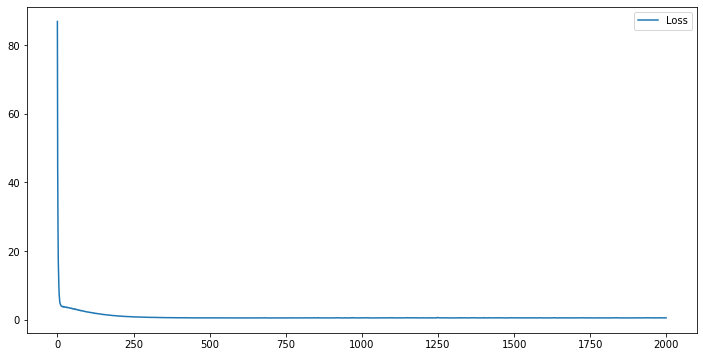

In [14]:
# and use them to train the model
loss_history = train(model, train_loader, criterion, optimizer, config)
loss_history_np = [loss.detach().cpu().numpy() for loss in loss_history]

plt.figure(figsize=(12, 6))
plt.plot(loss_history_np)
plt.legend(['Loss'])
plt.show()

In [15]:
def visualize_gam(x_values,input_dim, output_dim, vis_lat_features = False):
    # Plot learned functions
    fig, axes = plt.subplots(input_dim, output_dim, figsize=(15,30))

    feature_output_max = {} 
    feature_output_min = {}

    for j in range(output_dim):
        feature_output_max[f'output_{j}'] = []
        feature_output_min[f'output_{j}'] = []

    for i in range(input_dim):
        with torch.no_grad():
            feature_input = x_values
            for j in range(output_dim):
                if vis_lat_features:
                    # feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    # # plot without hirarchical model
                    feature_output = model.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy() 
                else:          
                    feature_output = model.NAM_output.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()

                feature_output_max[f'output_{j}'].append(max(feature_output)) 
                feature_output_min[f'output_{j}'].append(min(feature_output))

    for i in range(input_dim):
        with torch.no_grad(): 
            for j in range(output_dim):
                ax1 = axes[i, j]
                if vis_lat_features:
                    # feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    # # plot without hirarchical model
                    feature_output = model.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy() 
                else:          
                    feature_output = model.NAM_output.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    
                ax1.scatter(x_values.cpu().numpy(), feature_output, label=f'Feature {i+1}')
                ax1.set_title(f'Feature {i+1} to output {j}')
                ax1.set_xlabel('Input')
                ax1.set_ylabel('Output')
                ax1.set_ylim([min(feature_output_min[f'output_{j}'])*1.3, max(feature_output_max[f'output_{j}'])*1.3])

    plt.tight_layout()
    plt.show()
    return

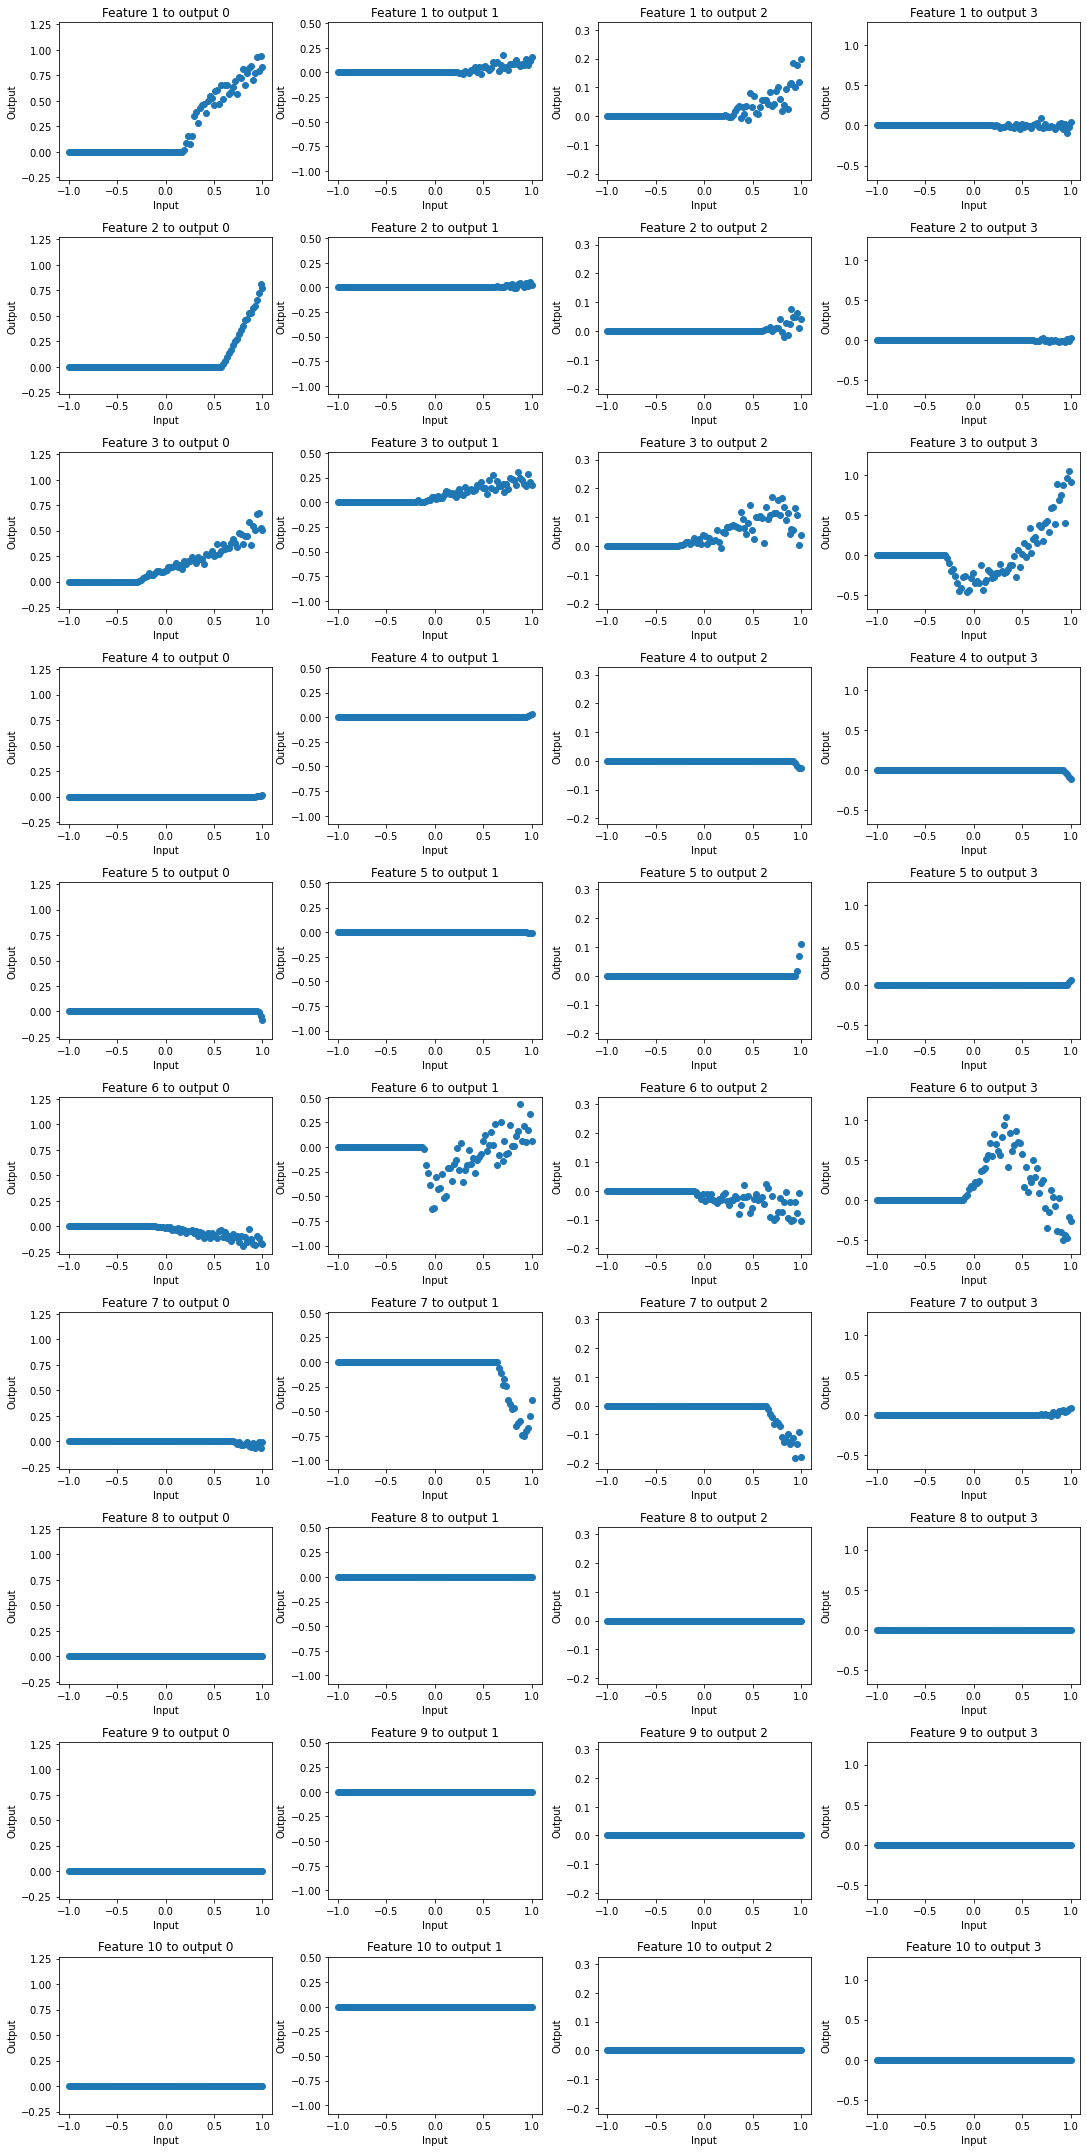

In [16]:
# Generate input values for plotting
x_values = torch.linspace(-1, 1, 100).reshape(-1, 1)  # 100 points between -1 and 1

vis_lat_features = True
input_dim = config['in_features']
output_dim = config['latent_dim']
visualize_gam(x_values, input_dim, output_dim, vis_lat_features)

AttributeError: 'NeuralAdditiveModel' object has no attribute 'NAM_features'

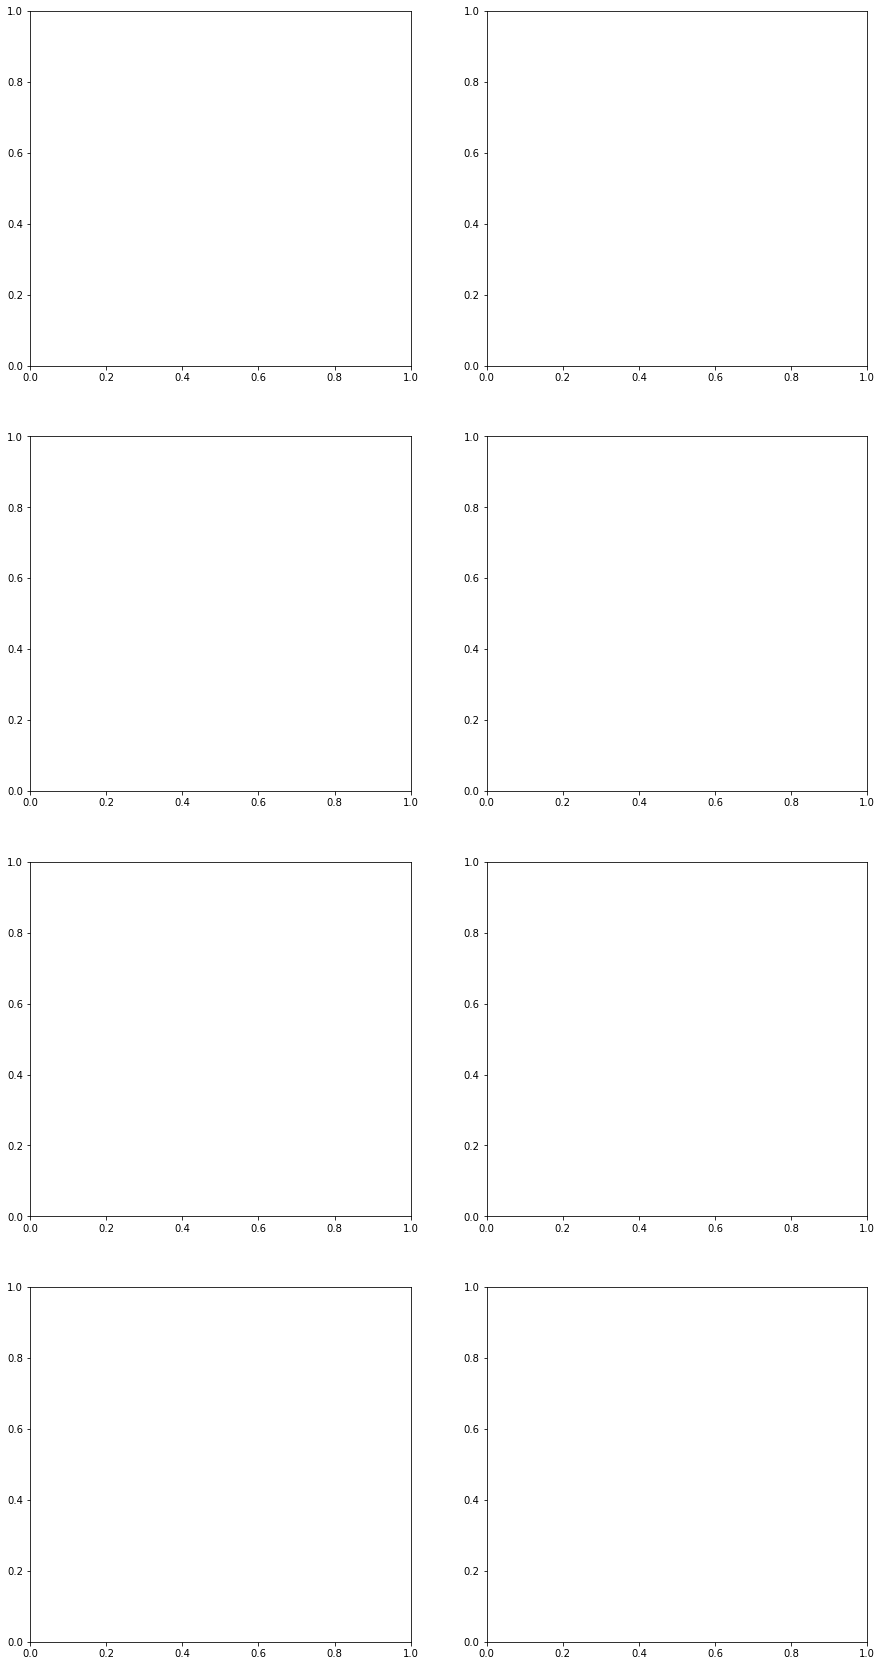

In [19]:
# Generate input values for plotting
x_values = torch.linspace(-1, 1, 100).reshape(-1, 1)  # 100 points between -1 and 1

vis_lat_features = True
input_dim = config['latent_dim']
output_dim = config['output_dim']
visualize_gam(x_values, input_dim, output_dim, vis_lat_features)

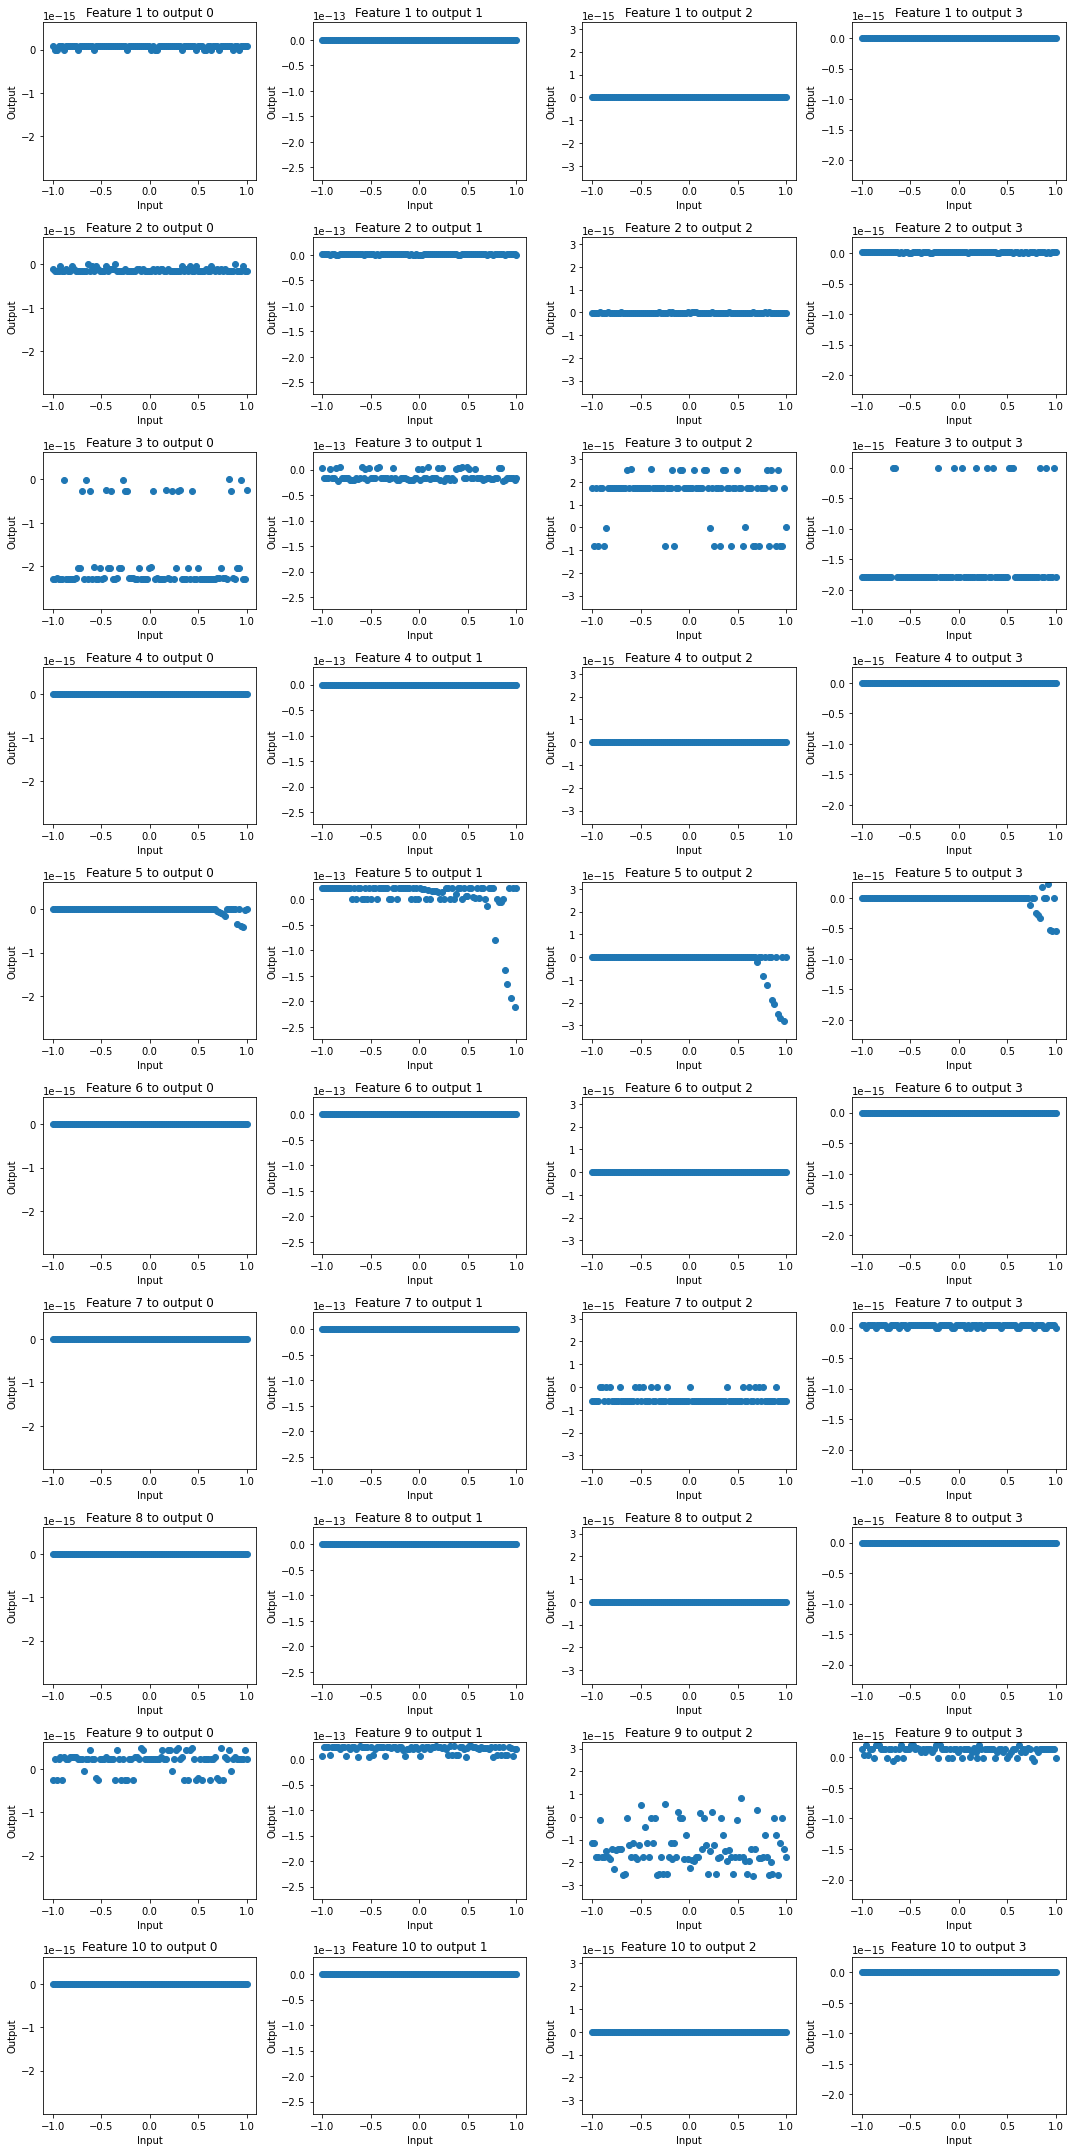

In [57]:
# Generate input values for plotting
x_values = torch.linspace(-1, 1, 100).reshape(-1, 1)  # 100 points between -1 and 1

vis_lat_features = True
input_dim = config['in_features']
output_dim = config['latent_dim']
visualize_gam(x_values, input_dim, output_dim, vis_lat_features)


# Old

In [10]:
# a basic numerical example that demonstrates the functionality of the key parts of the NeuralAdditiveModel class

if 0:
    import torch
    import torch.nn as nn

    # Simplified FeatureNN that outputs 3 values per feature (for 3 classes)
    class SimpleFeatureNN(nn.Module):
        def __init__(self, num_features, num_classes):
            super().__init__()
            self.input_layer = torch.nn.Linear(1, num_features)
            self.output_layer = torch.nn.Linear(num_features, num_classes)

        def forward(self, x):
            # Linear transformation: output = weight * x + bias
            x = self.input_layer(x)
            x = self.output_layer(x)
            return x

    # Simplified NeuralAdditiveModel
    class SimpleNeuralAdditiveModel(nn.Module):
        def __init__(self, num_features=5, num_classes=3):
            super().__init__()
            self.input_size = num_features
            self.feature_nns = nn.ModuleList([SimpleFeatureNN(num_features, num_classes) for _ in range(num_features)])
            self.bias = nn.Parameter(torch.tensor([0.5, 0.6, 0.7]))  # Bias for each class

        def forward(self, x):
            input_fe = self._feature_nns(x)
            print('-----------------')
            print(input_fe)
            # Collect outputs from each feature network
            f_out = torch.stack(input_fe, dim=-1)  # Shape: [batch_size, num_classes, num_features]
            print('-----------------')
            print(f_out)
            # Sum across features
            f_out_sum = f_out.sum(dim=-1)  # Shape: [batch_size, num_classes]
            print('-----------------')
            print(f_out_sum)
            # Add bias
            output = f_out_sum + self.bias
            print('-----------------')
            print(output)
            # Apply softmax to get class probabilities
            output = torch.softmax(output, dim=-1)
            print('-----------------')
            print(output)

            return output, f_out

        def _feature_nns(self, x):
            return [self.feature_nns[i](x[:, i].unsqueeze(-1)) for i in range(self.input_size)]

    # Step 3: Test the Model with a Simple Input

    # Define a simple input tensor with 2 features for 1 sample (batch_size = 1)
    x_input = torch.tensor([[1.0, 2.0, 1.5, 2.5, 3.0]])  # Shape: [1, 2] (1 sample, 2 features)
    print(x_input)
    # Initialize the simple model
    model = SimpleNeuralAdditiveModel(num_features=5, num_classes=3)

    # Perform a forward pass
    output, f_out = model(x_input)

In [80]:
input_size = x_data.shape[-1]
shallow_units = 500
hidden_units = (300, 100)

model = NeuralAdditiveModel(input_size=input_size,
                 shallow_units=shallow_units,
                 hidden_units=hidden_units,
                 shallow_layer = ExULayer,
                 hidden_layer = ReLULayer,
                 feature_dropout = 0.0,
                 hidden_dropout = 0.0,
                 )

lr=0.4
optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=lr,
                                  weight_decay=0.0
                             )
#criterion = torch.nn.MSELoss()
criterion = penalized_mse
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=100, epochs=1000)
#StepLR(optimizer, gamma=1, step_size=1)

train_dataset = TensorDataset(torch.tensor(x_data), torch.tensor(y_data))
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

<ipython-input-80-fcd7a1a4c170>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(x_data), torch.tensor(y_data))


train (100/5000) | loss = 31.83157: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.87it/s]
train (200/5000) | loss = 31.80177: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.38it/s]
train (300/5000) | loss = 31.78449: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.74it/s]
train (400/5000) | loss = 31.77496: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.61it/s]
train (500/5000) | loss = 31.76996: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.42it/s]
train (600/5000) | loss = 31.76748: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.91it/s]
train (700/5000) | loss = 31.76634: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.87it/s]
train (800/5000) | loss = 31.76584: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.98it/s]
train (900/5000) | loss = 31.76563: 100%

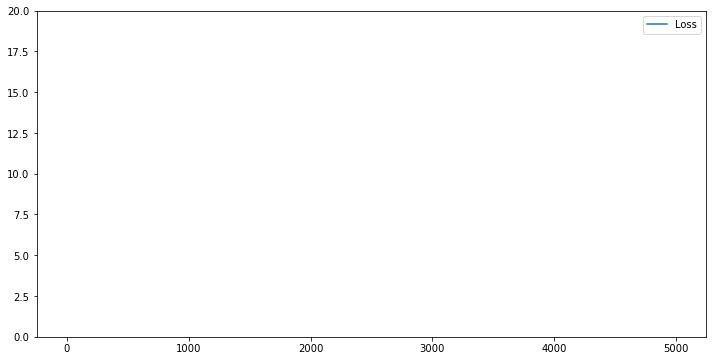

In [89]:
def train_one_epoch(model, criterion, optimizer, data_loader, device, epoch, n_epochs, verbose=False):
    pbar = tqdm.tqdm(enumerate(data_loader, start=1), total=len(data_loader), disable=not verbose)
    total_loss = 0
    for i, (x, y) in pbar:
        x, y = x.to(device), y.to(device)
        logits, fnns_out = model.forward(x)
        loss = criterion(logits, y, fnns_out, feature_penalty=0.0)
        #print(loss.item)
        total_loss += loss.item()
        #print(total_loss)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        pbar.set_description(f"train ({epoch+1}/{n_epochs}) | loss = {total_loss:.5f}")
        
    avg_loss = total_loss / len(data_loader)
    wandb.log({"loss": avg_loss})
    return avg_loss

history = []
n_epochs = 5000 #2000 #1000

for epoch in range(n_epochs):
    model = model.train()
    verbose = (epoch + 1) % 100 == 0
    total_loss = train_one_epoch(model, criterion, optimizer, train_loader, device, epoch, n_epochs, verbose=verbose)
    
    history.append(total_loss)
#     if verbose:
#         print(f"Epoch {epoch + 1} | Total Loss: {total_loss:.5f}")  
        
    scheduler.step()

plt.figure(figsize=(12, 6))
plt.plot(np.array(history))
plt.legend(['Loss'])
plt.ylim([0,20])
plt.show()

In [ ]:
def train_model(x_train, y_train, x_validate, y_validate, device):
    model = NeuralAdditiveModel(
        input_size=x_train.shape[-1],
        shallow_units=nam.data_utils.calculate_n_units(x_train, FLAGS.n_basis_functions, FLAGS.units_multiplier),
        hidden_units=list(map(int, FLAGS.hidden_units)),
        shallow_layer=ExULayer if FLAGS.shallow_layer == "exu" else ReLULayer,
        hidden_layer=ExULayer if FLAGS.hidden_layer == "exu" else ReLULayer,
        hidden_dropout=FLAGS.dropout,
        feature_dropout=FLAGS.feature_dropout).to(device)

    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=0.01,
                                  weight_decay=0.01)
    criterion = nam.metrics.penalized_mse if FLAGS.regression else nam.metrics.penalized_cross_entropy
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.995, step_size=1)

#     train_dataset = TensorDataset(torch.tensor(x_train), torch.tensor(y_train))
#     train_loader = DataLoader(train_dataset, batch_size=FLAGS.batch_size, shuffle=True)
#     validate_dataset = TensorDataset(torch.tensor(x_validate), torch.tensor(y_validate))
#     validate_loader = DataLoader(validate_dataset, batch_size=FLAGS.batch_size, shuffle=True)

#    n_tries = FLAGS.early_stopping_epochs
#    best_validation_score, best_weights = 0, None

    for epoch in range(5000):
        model = model.train()
        total_loss = train_one_epoch(model, criterion, optimizer, train_loader, device)
        logging.info(f"epoch {epoch} | train | {total_loss=}")

        scheduler.step()

#         model = model.eval()
#         metric, val_score = evaluate(model, validate_loader, device)
#         logging.info(f"epoch {epoch} | validate | {metric}={val_score}")

#         # early stopping
#         if val_score <= best_validation_score and n_tries > 0:
#             n_tries -= 1
#             continue
#         elif val_score <= best_validation_score:
#             logging.info(f"early stopping at epoch {epoch}")
#             break
#         best_validation_score = val_score
#         best_weights = copy.deepcopy(model.state_dict())

#     model.load_state_dict(best_weights)

    return model


def train_one_epoch(model, criterion, optimizer, data_loader, device):
    pbar = tqdm.tqdm(enumerate(data_loader, start=1), total=len(data_loader))
    total_loss = 0
    for i, (x, y) in pbar:
        x, y = x.to(device), y.to(device)
        logits, fnns_out = model.forward(x)
        loss = criterion(logits, y, fnns_out, feature_penalty=FLAGS.output_regularization)
        total_loss -= (total_loss / i) - (loss.item() / i)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"train | loss = {total_loss:.5f}")
    return total_loss